In [2]:
### packages
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
import datetime
import time
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import gaussian_kde

In [3]:
### Read CSV data
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2023, 1, 1)
numberofdates=start-end
print(numberofdates)
stocks = '000001.SS'
SSE = yf.download(stocks,start=start, end=end, interval='1d')
SSE.head()

-4748 days, 0:00:00


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,3289.750000,3295.279053,3243.319092,3243.760010,3243.760010,109400
2010-01-05,3254.468018,3290.511963,3221.461914,3282.178955,3282.178955,126200
2010-01-06,3277.517090,3295.867920,3253.043945,3254.215088,3254.215088,123600
2010-01-07,3253.990967,3268.819092,3176.707031,3192.775879,3192.775879,128600
2010-01-08,3177.259033,3198.919922,3149.017090,3195.997070,3195.997070,98400


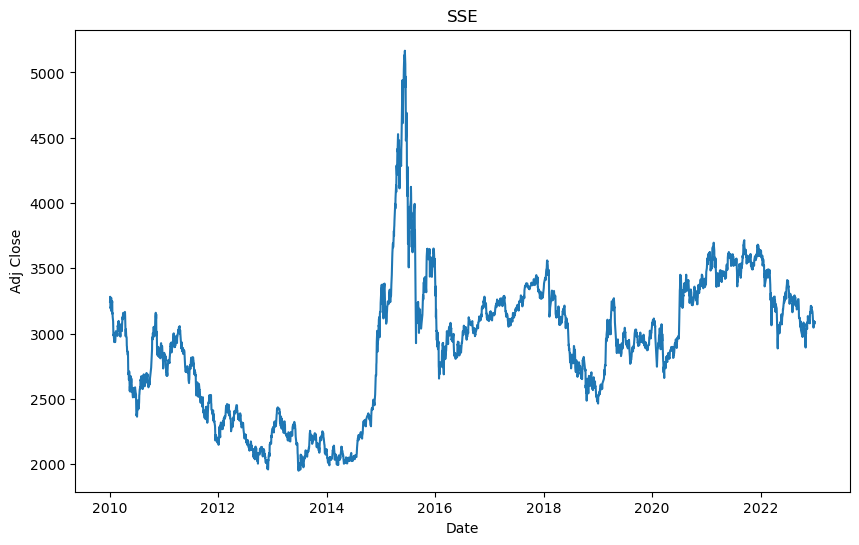

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(SSE.index,SSE['Adj Close'])
plt.title('SSE')
plt.ylabel('Adj Close')
plt.xlabel('Date')
plt.show()

In [13]:
### p-value &ADF test
print("p-value:%f" % adfuller(SSE["Adj Close"])[1])

p-value:0.152294


As the p-value is greater than level of significance, we fail to reject the null that a unit root is present in this time series.

In [14]:
returns = 100* SSE["Adj Close"].pct_change().dropna()

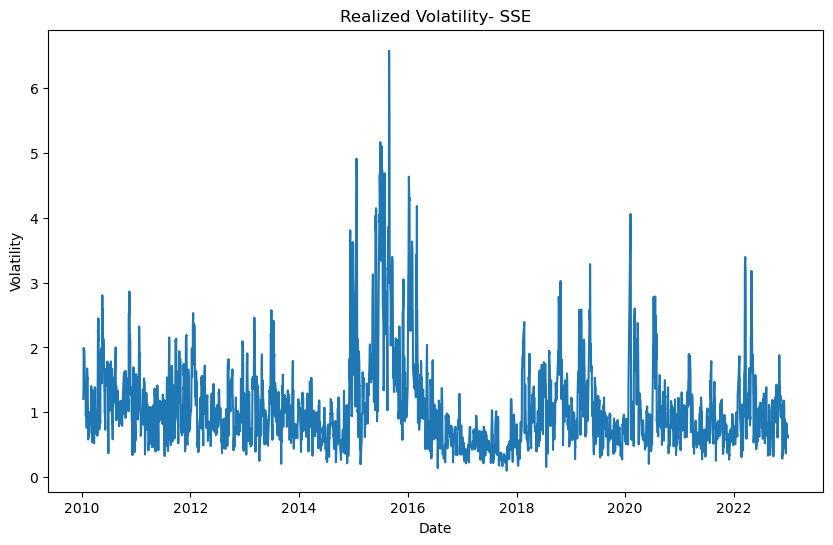

In [15]:
#graph returns
realized_vol = returns.rolling(5).std().dropna()
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility- SSE')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

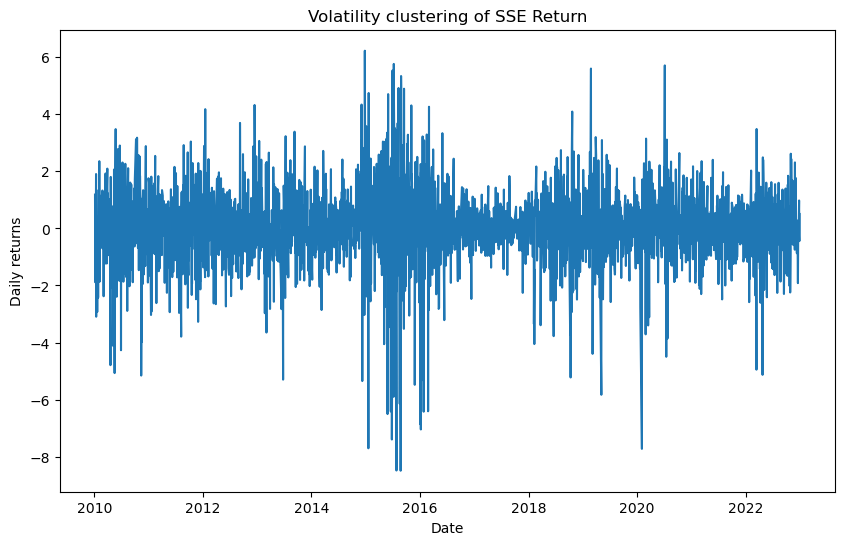

In [16]:
#graph volatility
plt.figure(figsize=(10, 6))
plt.plot(SSE.index[1:],returns)
plt.title('Volatility clustering of SSE Return')
plt.ylabel('Daily returns')
plt.xlabel('Date')
plt.show()

In [84]:
# Select the best arch model
n = 4748
split_date = returns.iloc[-n:].index

bic_arch = []
for p in range(1, 3):
        arch = arch_model(returns, mean='zero',vol='ARCH', p=p)\
            .fit(disp='off')
        bic_arch.append(arch.bic)
        if arch.bic == np.min(bic_arch):
            best_param_arch = p
arch = arch_model(returns, mean='zero', vol='ARCH',p=best_param_arch)\
            .fit(disp='off')
print(arch.summary())
forecast_arch = arch.forecast(start=split_date[0])
print(forecast_arch)

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5095.08
Distribution:                  Normal   AIC:                           10196.2
Method:            Maximum Likelihood   BIC:                           10214.3
                                        No. Observations:                 3148
Date:                Wed, Apr 10 2024   Df Residuals:                     3148
Time:                        23:17:30   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.0059  6.366e-02     15.800  3.109e-56   [  0.88

In [102]:
# Select the best garch model
bic_garch = []
for p in range(1, 3):
    for q in range(1, 3):
        garch = arch_model(returns, mean='zero',vol='GARCH', p=p, o=0, q=q)\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param_garch = p, q
garch = arch_model(returns, mean='zero', vol='GARCH',p=best_param_garch[0], o=0, q=best_param_garch[1])\
            .fit(disp='off')
print(garch.summary())
forecast_garch = garch.forecast(start=split_date[0])
print(forecast_garch)

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4895.31
Distribution:                  Normal   AIC:                           9796.62
Method:            Maximum Likelihood   BIC:                           9814.79
                                        No. Observations:                 3148
Date:                Wed, Apr 10 2024   Df Residuals:                     3148
Time:                        23:38:16   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0136  6.690e-03      2.026  4.275e-02 [4.

The best model selected is ARCH(2) and GARCH(1,1). Using AIC and BIC as our model selection criterion, GARCH(1,1) seems to be a even better model as it minimize aic and bic.

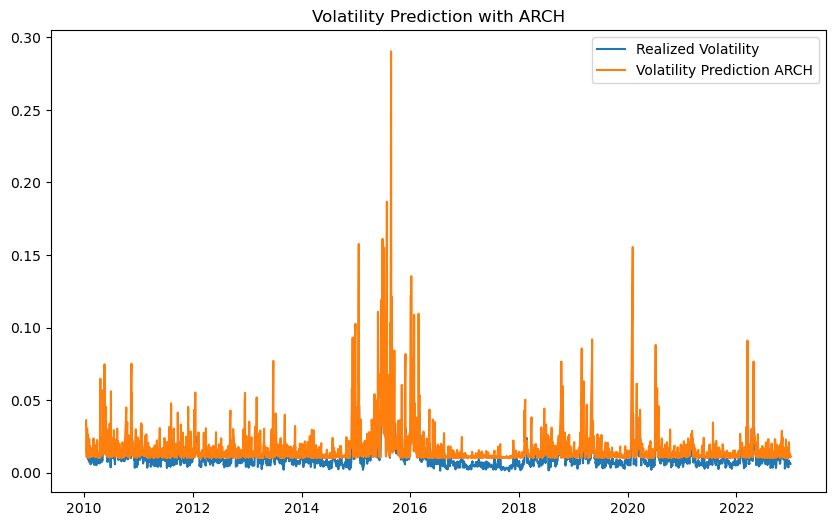

In [103]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100,
                  label='Volatility Prediction ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()

In [104]:
forecasted_volatility_arch = np.sqrt(forecast_arch.variance.dropna())
forecasted_volatility_aligned_arch = forecasted_volatility_arch.loc[realized_vol.index]
rmse_arch = np.sqrt(mean_squared_error(realized_vol, forecasted_volatility_aligned_arch))
print('RMSE for ARCH:', rmse_arch)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_actuals = y_true != 0
    return np.mean(np.abs((y_true[non_zero_actuals] - y_pred[non_zero_actuals]) / y_true[non_zero_actuals])) * 100

mape_arch = mean_absolute_percentage_error(realized_vol, forecasted_volatility_aligned_arch)
print(f'MAPE for ARCH: {mape_arch:.2f}%')

RMSE for ARCH: 0.5265668091652846
MAPE for ARCH: 77.26%


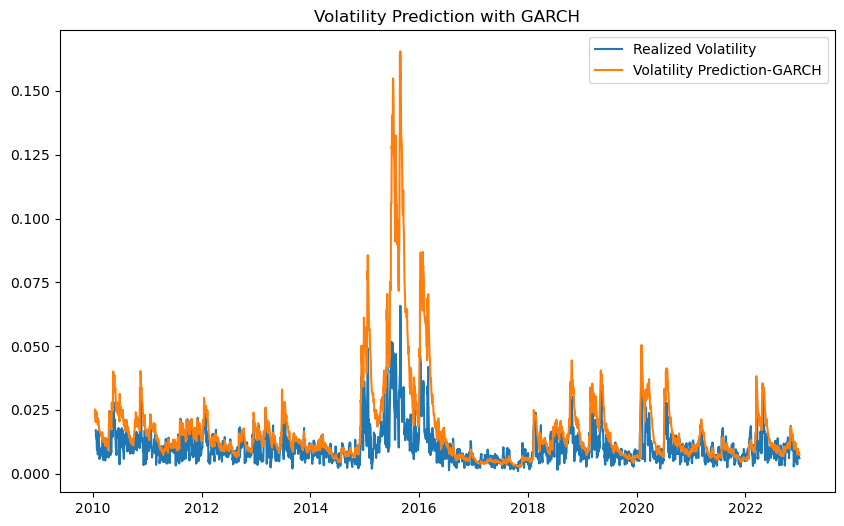

In [105]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100,
                  label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()

In [106]:
# Calculate forecasted volatility (square root of variance forecasts)
forecasted_volatility_garch = np.sqrt(forecast_garch.variance.dropna())
forecasted_volatility_aligned_garch = forecasted_volatility_garch.loc[realized_vol.index]
rmse_garch = np.sqrt(mean_squared_error(realized_vol, forecasted_volatility_aligned_garch))
print('RMSE for GARCH:', rmse_garch)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_actuals = y_true != 0
    return np.mean(np.abs((y_true[non_zero_actuals] - y_pred[non_zero_actuals]) / y_true[non_zero_actuals])) * 100

mape_garch = mean_absolute_percentage_error(realized_vol, forecasted_volatility_aligned_garch)
print(f'MAPE for GARCH: {mape_garch:.2f}%')

RMSE for GARCH: 0.43490858837947544
MAPE for GARCH: 78.80%


# ARMA-GARCH

In [111]:
# Select the best garch model
bic_armagarch = []
for p in range(1, 3):
    for q in range(1, 3):
        armagarch = arch_model(returns, mean='AR',vol='GARCH', p=p, o=0, q=q)\
                .fit(disp='off')
        bic_armagarch.append(armagarch.bic)
        if armagarch.bic == np.min(bic_armagarch):
            best_param_armagarch = p, q
armagarch = arch_model(returns, mean='AR', vol='GARCH',p=best_param_armagarch[0], o=0, q=best_param_armagarch[1])\
            .fit(disp='off')
print(armagarch.summary())
forecast_armagarch = armagarch.forecast(start=split_date[0])
print(forecast_armagarch)

                           AR - GARCH Model Results                           
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4895.09
Distribution:                  Normal   AIC:                           9798.17
Method:            Maximum Likelihood   BIC:                           9822.39
                                        No. Observations:                 3148
Date:                Wed, Apr 10 2024   Df Residuals:                     3147
Time:                        23:38:52   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0120  1.804e-02      0.664      0.506 

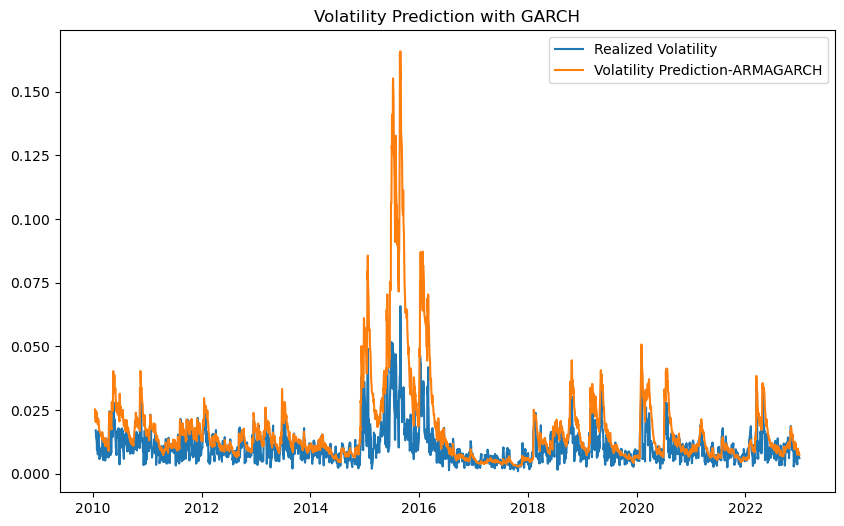

In [112]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_armagarch.variance.iloc[-len(split_date):] / 100,
                  label='Volatility Prediction-ARMAGARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()

In [114]:
# Calculate forecasted volatility (square root of variance forecasts)
forecasted_volatility_armaarch = np.sqrt(forecast_armagarch.variance.dropna())
forecasted_volatility_aligned_armagarch = forecasted_volatility_armaarch.loc[realized_vol.index]
rmse_armagarch = np.sqrt(mean_squared_error(realized_vol, forecasted_volatility_aligned_armaarch))
print('RMSE for ARMAGARCH:', rmse_armagarch)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_actuals = y_true != 0
    return np.mean(np.abs((y_true[non_zero_actuals] - y_pred[non_zero_actuals]) / y_true[non_zero_actuals])) * 100

mape_arma = mean_absolute_percentage_error(realized_vol, forecasted_volatility_aligned_armagarch)
print(f'MAPE for ARMAGARCH: {mape_arma:.2f}%')

RMSE for ARMAGARCH: 0.43490858837947544
MAPE for ARMAGARCH: 78.81%


# SVM-GARCH

In [71]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from arch import arch_model
from sklearn.metrics import mean_squared_error

# Assuming SSE is your DataFrame with stock data
returns = 100 * SSE["Adj Close"].pct_change().dropna()
realized_vol = returns.rolling(5).std().dropna()
# Predicting high (1) or low (0) volatility
median_vol = realized_vol.median()
vol_target = (realized_vol > median_vol).astype(int)

# We lag the features to avoid look-ahead bias
X = vol_target.shift(1).dropna()
y = vol_target.loc[X.index]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.values.reshape(-1, 1), y, test_size=0.2, random_state=42)

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Training the SVM model
svm_model = SVC(kernel='rbf', C=1.0)
svm_model.fit(X_train, y_train)

# Making predictions
y_pred = svm_model.predict(X_test)

# Evaluating the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Selecting a period of high volatility for fitting GARCH
# You might need to adjust this part according to your SVM model predictions and objectives
high_vol_period = realized_vol[realized_vol > median_vol]
returns_high_vol = returns.loc[high_vol_period.index]

# Assuming 'returns' is your DataFrame column of daily returns
train_size = int(len(returns) * 0.8)  # 80% of data for training
returns_train = returns[:train_size]
returns_test = returns[train_size:]

# Step 2: Fit the GARCH Model on Training Data
svmgarch_model = arch_model(returns_train, mean='Zero', vol='Garch', p=1, q=1)
svmgarch_fit = svmgarch_model.fit(disp='off')

# Step 3: Rolling Forecast for Testing Period
predicted_volatility = pd.Series(index=returns_test.index)

for end_date in returns_test.index:
    # Update the model with data up to the end date
    current_train = returns[:end_date]
    model = arch_model(current_train, mean='Zero', vol='Garch', p=1, q=1)
    model_fit = model.fit(disp='off', last_obs=end_date)
    
    # Forecast the next day's volatility
    forecast = model_fit.forecast(horizon=1)
    next_day_volatility = np.sqrt(forecast.variance.iloc[-1]).values[0]
    
    # Store the forecast
    predicted_volatility.loc[end_date] = next_day_volatility

# Step 4: Plot Actual vs. Predicted Volatility
# Calculate actual rolling volatility for the test set
actual_volatility_test = returns_test.rolling(window=5).std()


Accuracy: 0.8505564387917329


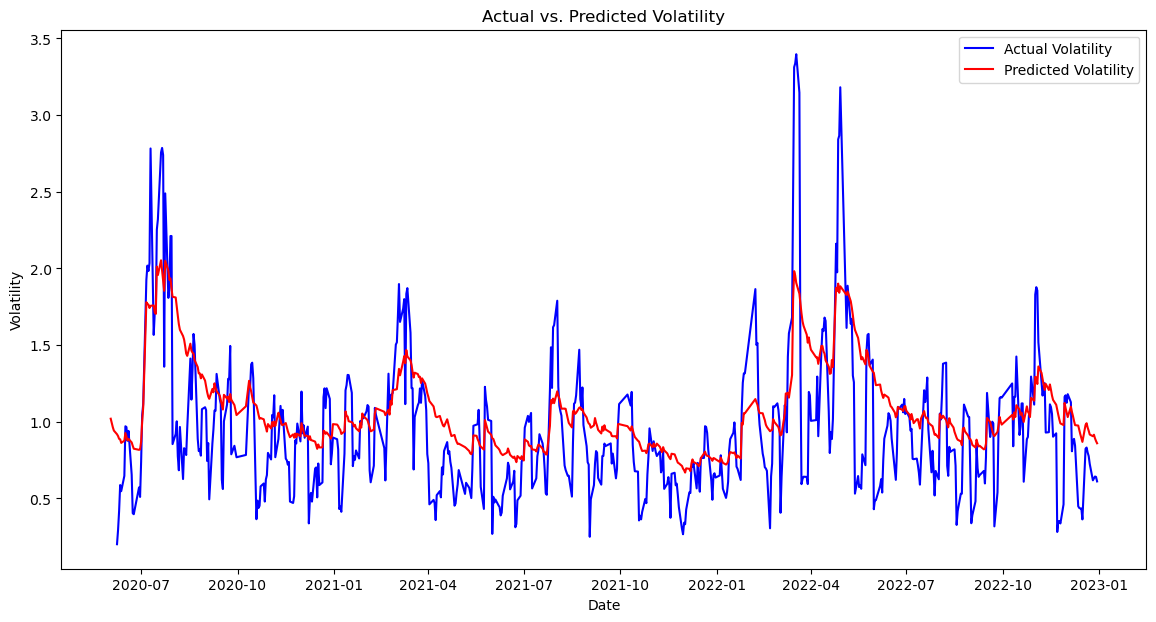

In [72]:
# Calculate actual rolling volatility for the test set
plt.figure(figsize=(14, 7))
plt.plot(actual_volatility_test, label='Actual Volatility', color='blue')
plt.plot(predicted_volatility, label='Predicted Volatility', color='red')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Actual vs. Predicted Volatility')
plt.legend()
plt.show()

In [110]:
actual_vol = actual_volatility_test.dropna()
predicted_vol = predicted_volatility[actual_vol.index]

# Calculate RMSE only for the overlapping dates
rmse_svm = np.sqrt(mean_squared_error(actual_vol, predicted_vol))
print('RMSE for SVM-GARCH:', rmse_svm)

def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Calculate mean absolute percentage error.
    Exclude zero values from the denominator.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_actuals = y_true != 0
    return np.mean(np.abs((y_true[non_zero_actuals] - y_pred[non_zero_actuals]) / y_true[non_zero_actuals])) * 100

# Calculate MAPE for non-zero actual values
mape = mean_absolute_percentage_error(actual_vol, predicted_vol)
print(f'MAPE for SVM-GARCH: {mape:.2f}%')

RMSE for SVM-GARCH: 0.35763932556606765
MAPE for SVM-GARCH: 39.43%


The SVM model in this context is used to forecast the conditional mean of returns, treating it as a regression problem. It aims to find a function that maps the input features (lagged returns) to the output variable (returns). The SVM algorithm finds the hyperplane that best fits the training data by maximizing the margin between the predicted values and the actual values of returns.